#EGU25-7276 | Orals | OS4.4 

# Enhanced Global Sea-Ice CFOSAT sigma₀ maps Reprocessing Utilizing HEALPix-Based Radar within the SROLL Framework  

Gallian, M., Delouis, J.-M., Girard-Ardhuin, F., Belaube, C., and Odaka, T.

Enhanced Global Sea-Ice CFOSAT sigma₀ maps Reprocessing Utilizing HEALPix-Based Radar within the SROLL Framework, EGU General Assembly 2025, Vienna, Austria, 27 Apr–2 May 2025, EGU25-7276, https://doi.org/10.5194/egusphere-egu25-7276, 2025.

In this presentation we investigate sea ice physical parameters by undertaking an extensive reanalysis of radar remote sensing data from SWIM and SCAT sensors onboard the french-chinse CFOSAT satellite. The central objective is to estimate daily maps of sea ice extent, type and displacement from radar sigma_0 data which is linked with surface roughness at a spatial resolution of 12.5 km. For this purpose, it is needed to know biais of the sigma₀ maps, this is what will be presented here. A significant challenge in processing sea-ice data is handling observations concentrated near the poles, where noteworthy features exist, while systematic instrument effects are more stable and manageable at lower latitudes, such as over continents. To prevent biases from arising due to geographic projections, we apply the HEALPix pixelization, functioning as a Discrete Global Grid System (DGGS). This technique enables us to process the complete dataset at once, extracting both instrumental biases and the relevant signal within a cohesive framework. The map production employs SROLL, a methodology originally crafted for processing cosmology data in the Planck mission. SROLL is tailored for calibrating, denoising, and producing consistent maps in a single operation, utilizing all available satellite data. We processed five years of SWIM observations and two years of SCAT data in one run gathering as much as possible all available information. Temporal gaps, related to the scanning strategy, were filled using spline-based interpolation, and detected antenna gain variations were adjusted. Additionally, analyses and compensation were performed for long-term noise fluctuations. The resulting datasets underwent successful validation against independent references, illustrating the approach's robustness. This work underscores SROLL's paradigm efficacy in satellite data processing and emphasizes its potential across space missions beyond cosmology. The data is publicly available in Zarr format, promoting ease of access and compatibility with the xDGGS framework.

# get the data

In this notebook we get the data using Zarr file and an Healpix grid. The following cells show how the plots shown during the EGU meeting has been produced.

In [23]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xdggs
import fsspec
from datetime import datetime, timedelta

data=xr.open_zarr('/mnt/d/cfosat_output/CFOSAT_ALL_SIGMA0.zarr').pipe(xdggs.decode)
data

RuntimeError: Zstd decompression error: invalid input data

In [2]:
time=data.time.compute().data
time=[(time[0].astype('M8[s]').astype(datetime)+timedelta(hours=k*12)).strftime('%Y-%m-%dT%H:%M') for k in range(len(time))]

# use XDDGS to visualise a subregion

In [3]:
lat = np.arange(-60, -55, 0.03)
lon = np.arange(-20, -15, 0.03)
full_lat = np.repeat(lat, len(lon))
full_lon = np.tile(lon, len(lat))
ds=data.SCAT_HH.dggs.sel_latlon(longitude=full_lon, latitude=full_lat).compute()#.dggs.explore(alpha=0.8)
ds.dggs.explore(alpha=0.8,cmap='coolwarm')

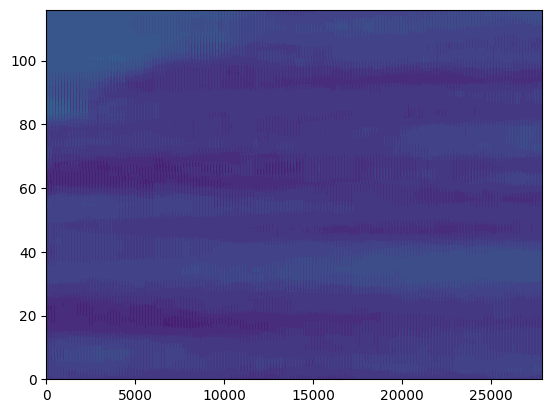

In [4]:
plt.contourf(ds.data,vmax=15)

1.0 0.0
1.0 0.0
1.0 0.0


([], [])

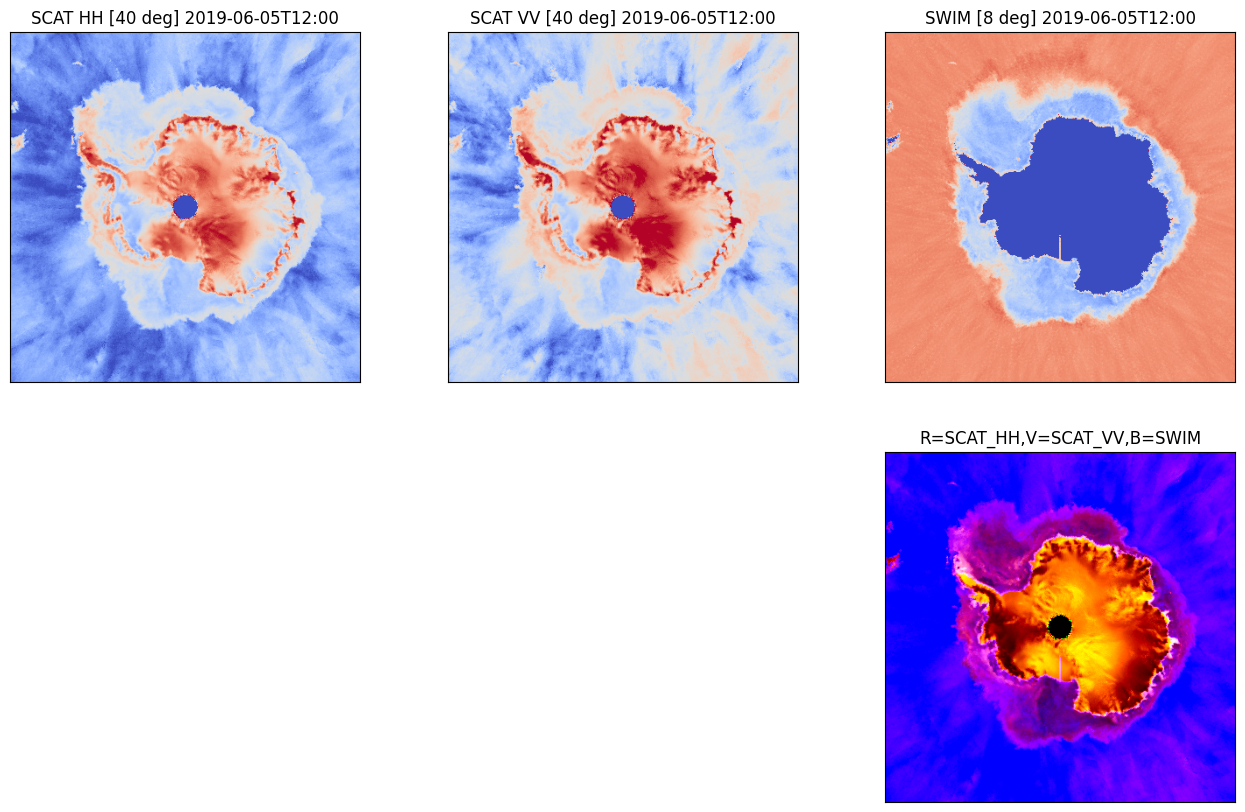

In [19]:
#compute the healpix projection at the north pole for level=9
xsize=400
pidx=hp.gnomview(np.arange(12*(4**9)),reso=12,rot=[0,-90],xsize=xsize,flip='astro',
                 return_projected_map=True,no_plot=True,nest=True).astype('int')
                 
# Setup
imhh=data.SCAT_HH.isel(time=0).compute().data
imvv=data.SCAT_VV.isel(time=0).compute().data
ims=data.SWIM.isel(time=0).compute().data

# initialise the plot
fig=plt.figure(figsize=(16,10))
plt.subplot(2,3,1)
tl1=plt.title('SCAT HH [40 deg] '+time[0])
ln1 = plt.imshow(imhh[pidx],cmap='coolwarm',vmin=-25,vmax=-5,origin='lower')
plt.xticks([])
plt.yticks([])
plt.subplot(2,3,2)
tl2=plt.title('SCAT VV [40 deg] '+time[0])
ln2 = plt.imshow(imvv[pidx],cmap='coolwarm',vmin=-25,vmax=-5,origin='lower')
plt.xticks([])
plt.yticks([])
plt.subplot(2,3,3)
tl3=plt.title('SWIM [8 deg] '+time[0])
ln3 = plt.imshow(ims[pidx],cmap='coolwarm',vmin=-10,vmax=15,origin='lower')
plt.xticks([])
plt.yticks([])
im=np.zeros([xsize,xsize,3])

a=-30
b=-8
a1=-20
b1=0
a2=-15
b2=5

im[:,:,0]=(np.clip(imhh[pidx],a,b)-a)/(b-a)
im[:,:,1]=(np.clip(imvv[pidx],a1,b1)-a1)/(b1-a1)
im[:,:,2]=(np.clip(ims[pidx],a2,b2)-a2)/(b2-a2)

for k in range(3):
    print(np.max(im[:,:,k]),np.min(im[:,:,k]))
    
plt.subplot(2,3,6)
tl4=plt.title('R=SCAT_HH,V=SCAT_VV,B=SWIM')
ln4 = plt.imshow(np.clip((im-0.35)*2,0.0,1.0),origin='lower')
plt.xticks([])
plt.yticks([])

0 117
1 117
2 117
3 117
4 117
5 117
6 117
7 117
8 117
9 117
10 117
11 117
12 117
13 117
14 117
15 117
16 117
17 117
18 117
19 117
20 117
21 117
22 117
23 117
24 117
25 117
26 117
27 117
28 117
29 117
30 117
31 117
32 117
33 117
34 117
35 117
36 117
37 117
38 117
39 117
40 117
41 117
42 117
43 117
44 117
45 117
46 117
47 117
48 117
49 117
50 117
51 117
52 117
53 117
54 117
55 117
56 117
57 117
58 117
59 117
60 117
61 117
62 117
63 117
64 117
65 117
66 117
67 117
68 117
69 117
70 117
71 117
72 117
73 117
74 117
75 117
76 117
77 117
78 117
79 117
80 117
81 117
82 117
83 117
84 117
85 117
86 117
87 117
88 117
89 117
90 117
91 117
92 117
93 117
94 117
95 117
96 117
97 117
98 117
99 117
100 117
101 117
102 117
103 117
104 117
105 117
106 117
107 117
108 117
109 117
110 117
111 117
112 117
113 117
114 117
115 117
116 117


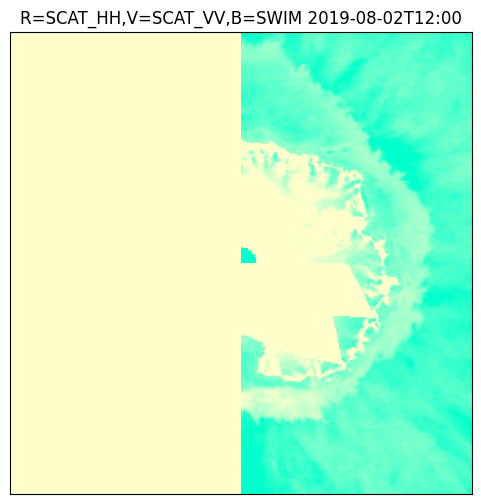

In [20]:
from matplotlib.animation import FuncAnimation, FFMpegWriter

# Setup
imhh=data.SCAT_HH.isel(time=0).compute().data
imvv=data.SCAT_VV.isel(time=0).compute().data
ims=data.SWIM.isel(time=0).compute().data

# initialise the plot
fig=plt.figure(figsize=(6,6))
im=np.zeros([xsize,xsize,3])

im[:,:,0]=(np.clip(imhh[pidx],a,b)-a)/(b-a)
im[:,:,1]=(np.clip(imvv[pidx],a1,b1)-a1)/(b1-a1)
im[:,:,2]=(np.clip(ims[pidx],a2,b2)-a2)/(b2-a2)
    
tl1 = plt.title('R=SCAT_HH,V=SCAT_VV,B=SWIM '+time[0])
ln1 = plt.imshow(np.clip((im-0.35)*2,0.0,1.0),origin='lower')
plt.xticks([])
plt.yticks([])

def init():
    return ln1,tl1

# Fonction d’update
def update(frame):
    imhh=data.SCAT_HH.isel(time=frame).compute().data
    imvv=data.SCAT_VV.isel(time=frame).compute().data
    ims=data.SWIM.isel(time=frame).compute().data
    im[:,:,0]=(np.clip(imhh[pidx],a,b)-a)/(b-a)
    im[:,:,1]=(np.clip(imvv[pidx],a1,b1)-a1)/(b1-a1)
    im[:,:,2]=(np.clip(ims[pidx],a2,b2)-a2)/(b2-a2)
    ln1.set_data(np.clip((im-0.35)*2,0.0,1.0))
    tl1.set_text('R=SCAT_HH,V=SCAT_VV,B=SWIM '+time[frame])
    print(frame,ntest)
    return ln1, tl1

# run the animation
ntest=len(time)
ani = FuncAnimation(fig, update, frames=np.arange(ntest),
                    init_func=init, blit=True)

# Define an MP4 writer
writer = FFMpegWriter(fps=15, bitrate=1800)

# Save the animation
ani.save('/mnt/d/EGU_ANIM.mp4', writer=writer)